In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data/daily_close.csv', index_col=[0])

In [89]:
def get_headge_ratio(ticker1, ticker2, data):
    X = sm.add_constant(data[ticker1])
    y = data[ticker2]
    model = sm.OLS(y, X).fit()
    hedge_ratio = model.params[ticker1]

    return hedge_ratio


def spread(ticker1, ticker2, data, hedge_ratio):
    S2_bought = 100
    S1_bought = int(100*hedge_ratio)
    spread_v = 100*data[ticker2].iloc[-1] - int(100*hedge_ratio)*data[ticker1].iloc[-1]
    return spread_v, -1*S1_bought, S2_bought


In [91]:
hedge_ratio = get_headge_ratio('APOLLOHOSP','SUNPHARMA', data[:int(len(data)*0.7)])
spread('APOLLOHOSP','SUNPHARMA', data[:int(len(data)*0.7)], hedge_ratio)

(42862.40139999999, -14, 100)

In [95]:
t_values = range(0, len(data) - int(len(data)*0.7))
spread_values_list = []
dates = []

for t in tqdm.tqdm(t_values):
    spread_values_list.append(spread('APOLLOHOSP','SUNPHARMA', data[:int(len(data)*0.7) + t], hedge_ratio)[0])
    dates.append(data[:int(len(data)*0.7) + t].index[-1])

100%|██████████| 421/421 [00:00<00:00, 8786.96it/s]


In [96]:
spread_values_list

[42862.40139999999,
 43247.000000000015,
 43762.59859999998,
 43135.0986,
 43342.09860000001,
 43407.000000000015,
 43771.59859999998,
 42898.302800000005,
 43252.9014,
 42346.69720000001,
 44816.197199999995,
 44721.0,
 43196.302800000005,
 43694.802800000005,
 43712.90140000002,
 45226.80280000002,
 44334.30280000002,
 43381.30279999999,
 41046.302800000005,
 41833.19719999998,
 42520.0986,
 42948.5986,
 43936.500000000015,
 42479.697199999995,
 41716.4014,
 41251.30279999999,
 41886.5,
 41642.802800000005,
 41716.197199999995,
 41575.0986,
 43126.09860000001,
 44287.802800000005,
 43226.197199999995,
 43276.802800000005,
 45658.500000000015,
 44191.302800000005,
 44534.302800000005,
 42671.302800000005,
 43991.4014,
 43725.802800000005,
 43507.197199999995,
 43735.5,
 41381.40139999999,
 44468.302800000005,
 44866.999999999985,
 41965.19719999998,
 42690.697199999995,
 45179.0986,
 46116.697199999995,
 43453.5986,
 44035.999999999985,
 44202.29999999999,
 44690.9014,
 44940.69720000

In [99]:
def plot_spread(ticker1, ticker2, data):
    t_values = range(0, len(data) - int(len(data)*0.7))
    spread_values_list = []
    dates = []

    for t in tqdm.tqdm(t_values):
        spread_values_list.append(spread('APOLLOHOSP','SUNPHARMA', data[:int(len(data)*0.7) + t], hedge_ratio)[0])
        dates.append(data[:int(len(data)*0.7) + t].index[-1])
    
    plt.figure(figsize=(12, 6))
    plt.plot(dates, spread_values_list)
    plt.title(f'Spread between {ticker1} and {ticker2}')
    plt.xlabel('Date')
    plt.ylabel('Spread Value')
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.xticks(dates[::len(dates)//50])
    plt.tight_layout()
    plt.show()


100%|██████████| 421/421 [00:00<00:00, 11229.05it/s]


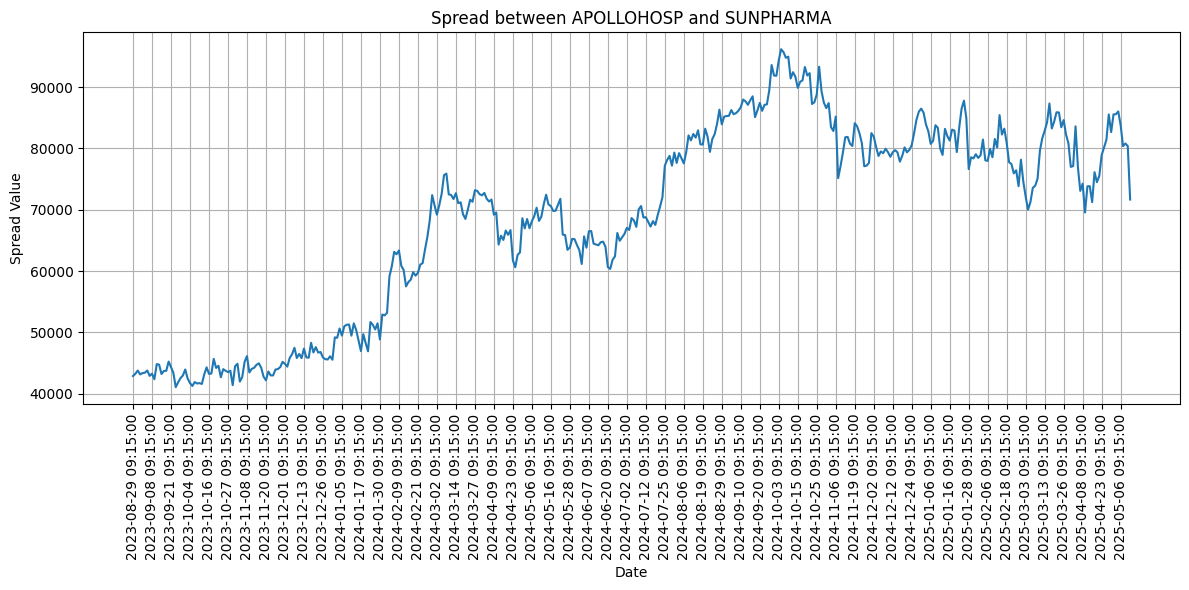

In [100]:
plot_spread('APOLLOHOSP','SUNPHARMA', data)

In [101]:
def get_polynomial_slope(spread_values_list, dates, closness):
    degree = min(int(len(dates) / closness) + 1, len(dates)-1)
    x = np.arange(len(dates))
    y = np.array(spread_values_list)
    
    coeffs = np.polyfit(x, y, degree)
    polynomial = np.poly1d(coeffs)
    
    slope = polynomial.deriv()(x[-1])    
    return slope


In [102]:
def make_slope_curve(spread_values_list, dates, closness):
    slopes = []
    for i in range(10, len(spread_values_list)):
        slope = get_polynomial_slope(spread_values_list[0:i], dates[0:i], closness)
        slopes.append(slope)
    plt.figure(figsize=(12, 8))
    plt.plot(dates[10:], slopes)
    plt.xlabel('time')
    plt.ylabel('Slope Value')
    plt.grid(True)
    plt.xticks(rotation=90)
    plt.xticks(dates[::len(dates)//50])
    plt.tight_layout()
    plt.show()

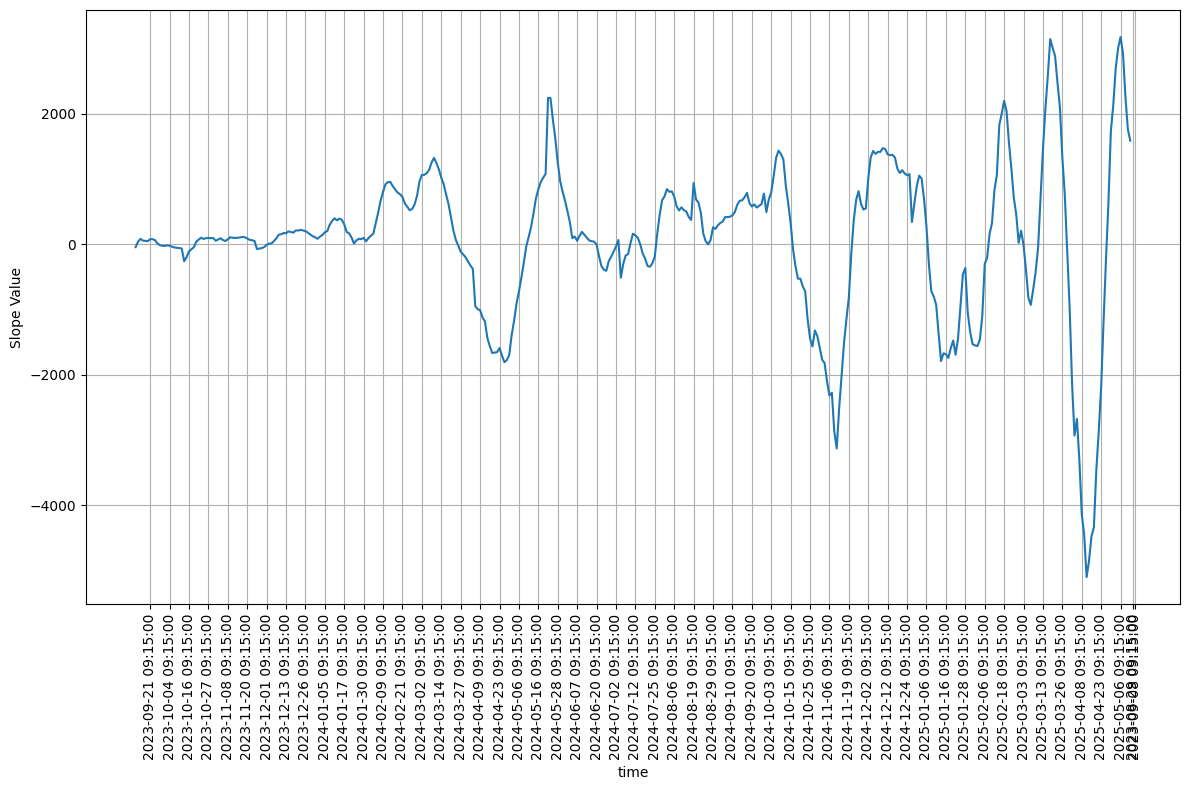

In [103]:
make_slope_curve(spread_values_list, dates, 30)

In [104]:
def get_signals(spread_values_list, dates, closness, quantity_S1, quantity_S2):
    slopes = []
    signals = []
    order_book = []
    for i in range(10, len(spread_values_list)):
        slope = get_polynomial_slope(spread_values_list[0:i], dates[0:i], closness)
        if len(slopes) > 0:
            if slopes[-1] > 0 and slope < 0:
                signals.append((dates[i], "buy", spread_values_list[i]))
                order_book.append((dates[i], quantity_S1, quantity_S2))
            if slopes[-1] < 0 and slope > 0:
                signals.append((dates[i], "sell", spread_values_list[i]))
                order_book.append((dates[i], -1*quantity_S1, -1*quantity_S2))
        slopes.append(slope)
    return signals, order_book 

COALINDIA – ONGC

In [118]:
ticker1 = 'COALINDIA'
ticker2 = 'ONGC'

hedge_ratio = get_headge_ratio(ticker1,ticker2, data[:int(len(data)*0.7)])
_, quantity_S1, quantity_S2 = spread(ticker1,ticker2, data[:int(len(data)*0.7)], hedge_ratio)

t_values = range(0, len(data) - int(len(data)*0.7))
spread_values_list = []
dates = []

for t in tqdm.tqdm(t_values):
    spread_values_list.append(spread(ticker1,ticker2, data[:int(len(data)*0.7) + t], hedge_ratio)[0])
    dates.append(data[:int(len(data)*0.7) + t].index[-1])

100%|██████████| 421/421 [00:00<00:00, 13177.63it/s]


In [134]:
signals, order_book = get_signals(spread_values_list, dates, 100, quantity_S1, quantity_S2)

In [135]:
signals

[('2024-01-23 09:15:00', 'sell', 471.9995999999992),
 ('2024-06-20 09:15:00', 'buy', -1803.9984000000004),
 ('2024-08-13 09:15:00', 'sell', 2284.9990000000034),
 ('2024-09-16 09:15:00', 'buy', -345.0),
 ('2024-11-13 09:15:00', 'sell', 841.0),
 ('2025-04-08 09:15:00', 'buy', -305.0)]

In [136]:
total_profit = 0
for date, signal, price in signals:
    if signal == "sell":
        total_profit += price
    if signal == "buy":
        total_profit -= price

In [137]:
total_profit

6051.997000000003

In [138]:
order_book

[('2024-01-23 09:15:00', 60, -100),
 ('2024-06-20 09:15:00', -60, 100),
 ('2024-08-13 09:15:00', 60, -100),
 ('2024-09-16 09:15:00', -60, 100),
 ('2024-11-13 09:15:00', 60, -100),
 ('2025-04-08 09:15:00', -60, 100)]